In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%pylab inline

np.random.seed(
    abs(hash('mit') // (2 ** 32 -1))
)

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

from keras.layers import (
    SimpleRNN, Dense, LSTM,
    Embedding, Input, Dropout,
    Concatenate,Bidirectional,
    GlobalAveragePooling1D
)
from keras.models import Model
import keras.backend as K

Populating the interactive namespace from numpy and matplotlib


# Data Acquisition

In [47]:
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"

train = pd.read_csv(data_folder+'class_training_set.csv')
meta_train_full = pd.read_csv(data_folder+'class_training_set_meta.csv')

meta_test = pd.read_csv(data_folder+'class_test_set_meta.csv')
meta_test_full = pd.read_csv(data_folder+'class_test_set_meta.csv')

In [53]:
# Data Folder
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"


##### TRAIN
# Light GBM
pred_train= pd.read_csv(data_folder+'predictions_train.csv')
#Optimal Tree with Hyperplans
opt_train = np.loadtxt(data_folder+'Opt_Tree_predict_train.txt')
opt_train = pd.DataFrame(opt_train).assign(object_id =pd.Series(pred_train.object_id).values)
opt_train.columns = pred.columns
# Rnn
#TBD




##### TEST
# Light GBM
pred= pd.read_csv(data_folder+'predictions_test.csv')
#Optimal Tree with Hyperplans
opt = np.loadtxt(data_folder+'Opt_Tree_predict_test.txt')
opt = pd.DataFrame(opt).assign(object_id =pd.Series(pred.object_id).values)
opt.columns = pred.columns
# Rnn
#TBD

In [49]:
y_train = np.array(meta_train_full.target)
unique_y_train =np.unique(y_train)
class_map_train = dict()
for i,val in enumerate(unique_y_train):
    class_map_train[val] = i
        
y_map_train = np.zeros((y_train.shape[0],))
y_map_train = np.array([class_map_train[val] for val in y_train])



y_test = np.array(meta_test_full.target)
unique_y_test =np.unique(y_test)
class_map_test = dict()
for i,val in enumerate(unique_y_test):
    class_map_test[val] = i
        
y_map_test = np.zeros((y_test.shape[0],))
y_map_test = np.array([class_map_test[val] for val in y_test])


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


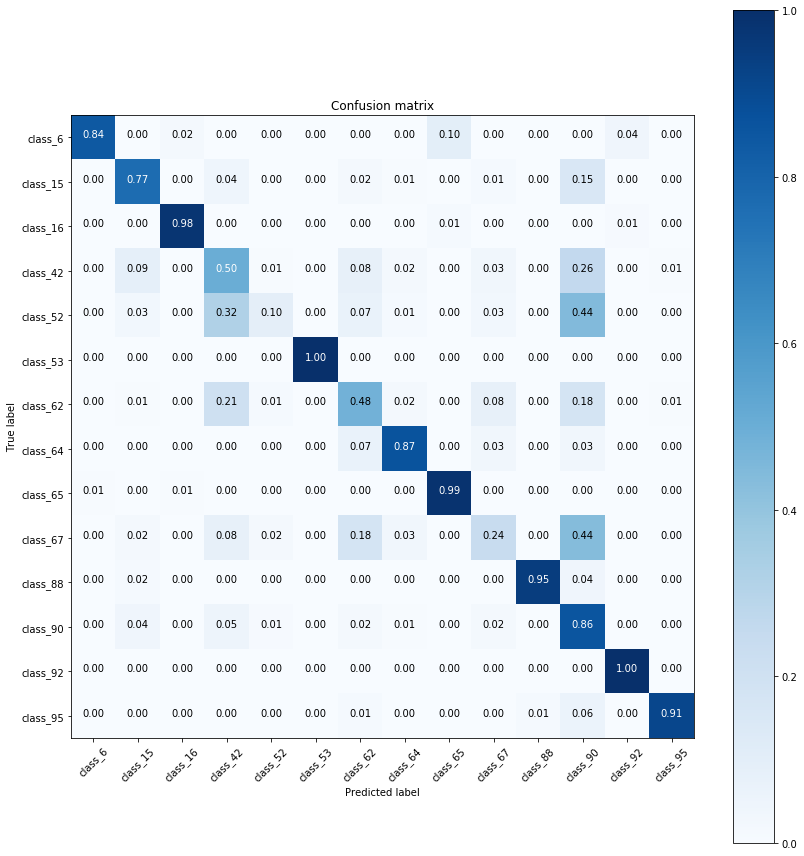

In [51]:
youssef = (0.7*pred+0.3*opt)/2
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [52]:
print('Light GBM Accuracy:' + str(accuracy_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))))
print('Optimal Tree + H Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1))))
print('Ensemble Manual Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))))


Light GBM Accuracy:0.7633204633204633
Optimal Tree + H Accuracy:0.6710424710424711
Ensemble Manual Accuracy:0.7822393822393823


In [65]:
K.clear_session()
# Your code here
# don't forget to compile your model

model_input_1 = Input(shape=(14,)
)
hidden_state_1 = Dense(64, activation='relu')(model_input_1)
hidden_state_1 = Dropout(0.2)(hidden_state_1)
hidden_state_1 = Dense(64, activation='relu')(hidden_state_1)
hidden_state_1 = Dropout(0.2)(hidden_state_1)


model_input_2 = Input(shape=(14,)
)
hidden_state_2 = Dense(64, activation='relu')(model_input_2)
hidden_state_2 = Dropout(0.2)(hidden_state_2)
hidden_state_2 = Dense(64, activation='relu')(hidden_state_2)
hidden_state_2 = Dropout(0.2)(hidden_state_2)


hidden_state = Concatenate()([
    hidden_state_1,
    hidden_state_2, 
])

hidden_state = Dense(64, activation='relu')(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(64, activation='relu')(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)

output = Dense(14, activation='softmax')(hidden_state)
model = Model([model_input_1 ,model_input_2], output)
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [71]:
num_samples_to_train = 50
model.fit(
    [pred_train.drop('object_id',axis=1),opt_train.drop('object_id',axis=1)], 
    pd.get_dummies(y_train), 
    epochs=1000, shuffle=True, batch_size=num_samples_to_train, verbose=0
)
#accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(int_sequences_test), axis=1).astype(int))

In [72]:
ens = model.predict([pred.drop('object_id',axis=1),opt.drop('object_id',axis=1)])
ens = pd.DataFrame(ens).assign(object_id =pd.Series(pred.object_id).values)
ens.columns = pred.columns

Normalized confusion matrix


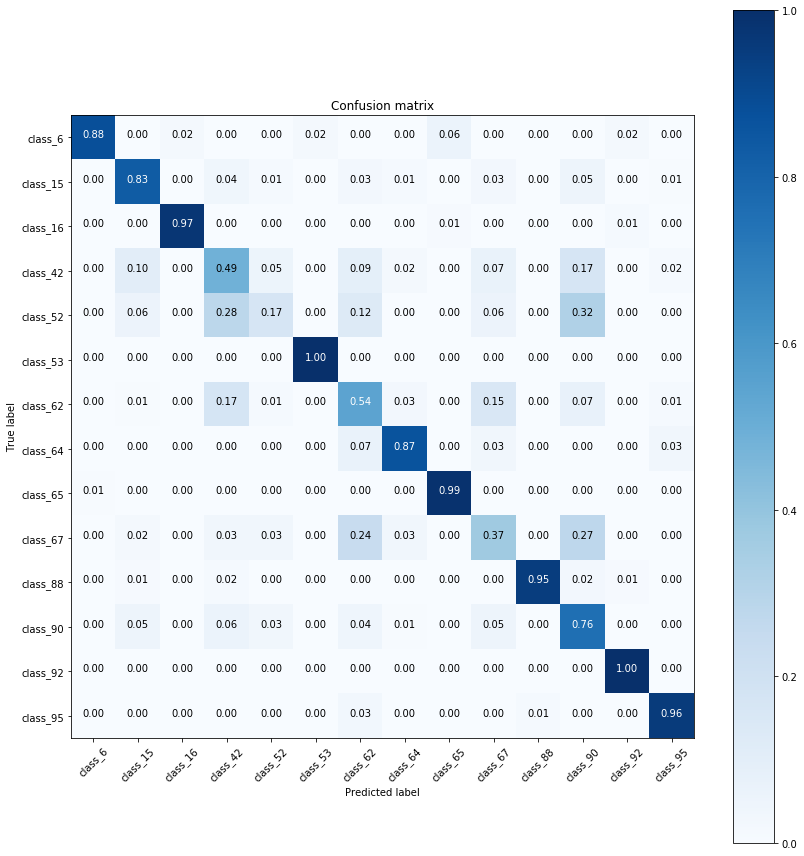

In [73]:
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


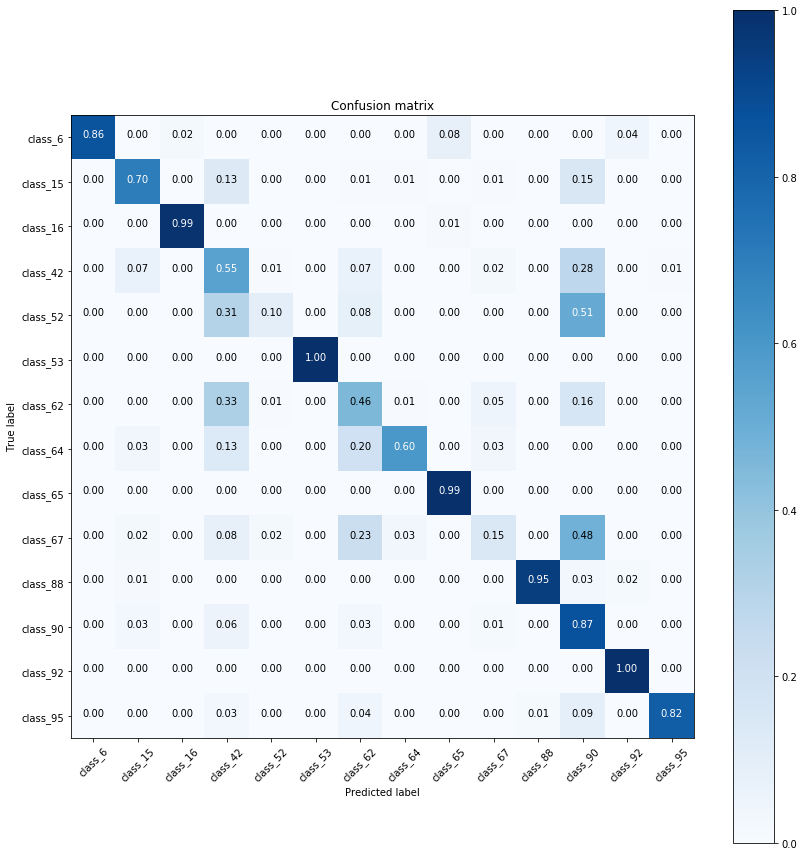

In [74]:
youssef = ens
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [75]:
print('Ensemble Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))))


Ensemble Accuracy:0.783011583011583
